# **IMPORT LIBRARIES**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller



# **LOAD DATA**

In [2]:
from google.colab import files
uploaded = files.upload()
file_name = list(uploaded.keys())[0]

df = pd.read_csv(file_name)

Saving water_filter_shop_sales_Data_2025.csv to water_filter_shop_sales_Data_2025.csv


# **BASIC DATA CHECK**

In [3]:
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3459 entries, 0 to 3458
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Invoice_ID     3459 non-null   object
 1   month          3459 non-null   object
 2   Product_Type   3459 non-null   object
 3   Quantity       3459 non-null   int64 
 4   Unit_Price     3459 non-null   int64 
 5   Total_Sale     3459 non-null   int64 
 6   Customer_Type  3459 non-null   object
 7   Location       3459 non-null   object
 8   Payment_Mode   3459 non-null   object
 9   Service_Type   3459 non-null   object
dtypes: int64(3), object(7)
memory usage: 270.4+ KB


,0
Invoice_ID,0
month,0
Product_Type,0
Quantity,0
Unit_Price,0
Total_Sale,0
Customer_Type,0
Location,0
Payment_Mode,0
Service_Type,0


In [4]:
df.head()

,Invoice_ID,month,Product_Type,Quantity,Unit_Price,Total_Sale,Customer_Type,Location,Payment_Mode,Service_Type
0,INV00001,January,Accessories,4,1060,4240,Institution,Suburbs,Cash,New Purchase
1,INV00004,January,Accessories,2,666,1332,Business,Suburbs,Card,New Purchase
2,INV00006,January,Accessories,3,287,861,Business,Suburbs,Online,New Purchase
3,INV00035,January,Accessories,3,234,702,Institution,Suburbs,Cash,New Purchase
4,INV00036,January,Accessories,2,1304,2608,Institution,Downtown,Cash,New Purchase


In [5]:
df.tail()

,Invoice_ID,month,Product_Type,Quantity,Unit_Price,Total_Sale,Customer_Type,Location,Payment_Mode,Service_Type
3454,INV03723,December,Water Purifier,2,40532,81064,Business,Downtown,Cash,New Purchase
3455,INV03724,December,Maintenance,1,5000,5000,Business,Downtown,Online,New Purchase
3456,INV03725,December,Accessories,4,5000,20000,Institution,City Center,Card,Maintenance
3457,INV03726,December,Water Purifier,4,5000,20000,Institution,Industrial Area,Online,Maintenance
3458,INV03727,December,Maintenance,1,12631,12631,Business,Downtown,Card,New Purchase


# **FEATURE ENGINEERING**
Convert months to numeric(for seasonality & forecasting)

In [6]:
month_map = {
    'January':1, 'February':2, 'March':3, 'April':4,
    'May':5, 'June':6, 'July':7, 'August':8,
    'September':9, 'October':10, 'November':11, 'December':12
}

df['Month_Num'] = df['month'].map(month_map)

**Outlier Analysis (sales Distibution)**

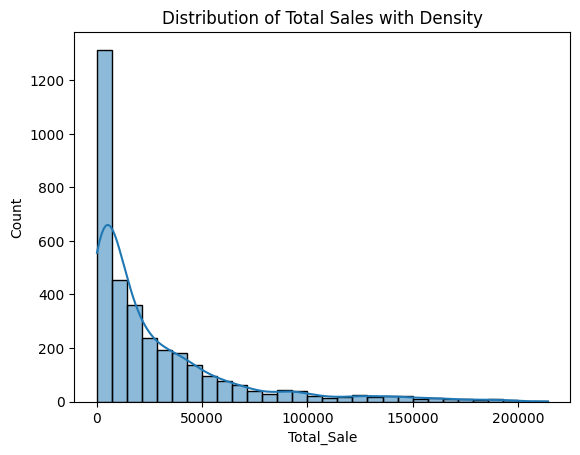

In [7]:
sns.histplot(df["Total_Sale"], bins=30, kde=True)
plt.title("Distribution of Total Sales with Density")
plt.show()


**DISTRIBUTION ANALYSIS**

Distribution of Total Sales

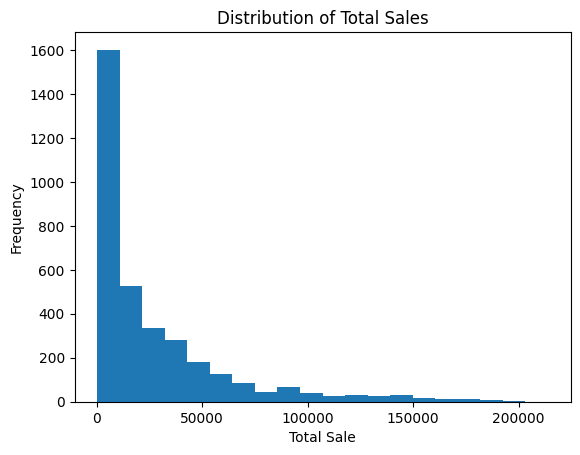

In [8]:
plt.figure()
plt.hist(df["Total_Sale"], bins=20)
plt.title("Distribution of Total Sales")
plt.xlabel("Total Sale")
plt.ylabel("Frequency")
plt.show()


# **EXPLORATORY DATA ANALYSIS (EDA)**

**Sales by Product Type**

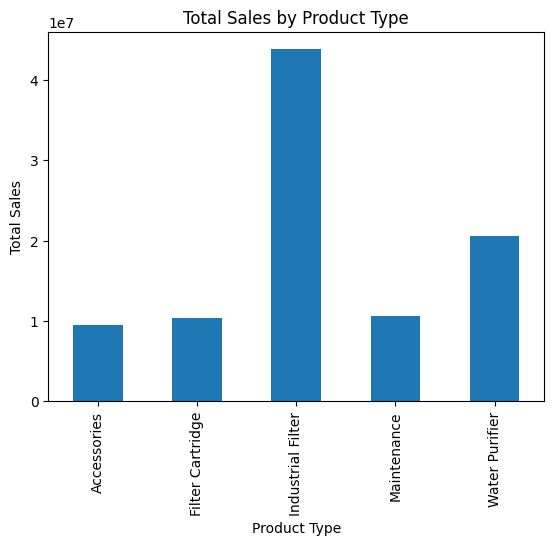

In [9]:
df.groupby("Product_Type")["Total_Sale"].sum().plot(kind="bar")
plt.title("Total Sales by Product Type")
plt.xlabel("Product Type")
plt.ylabel("Total Sales")
plt.show()


**Total sales per each product**

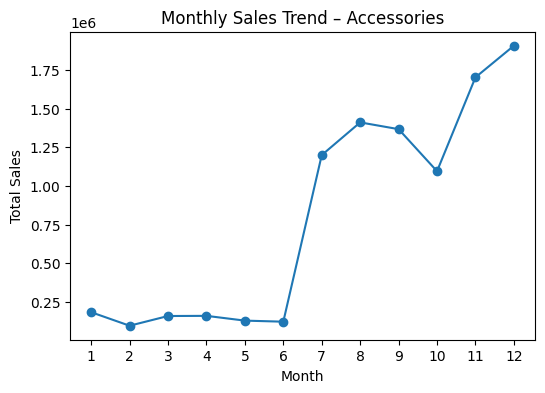

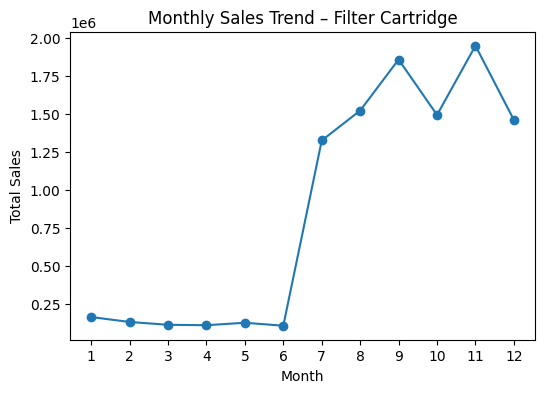

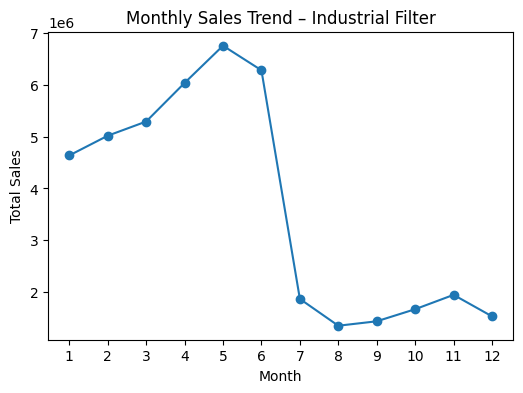

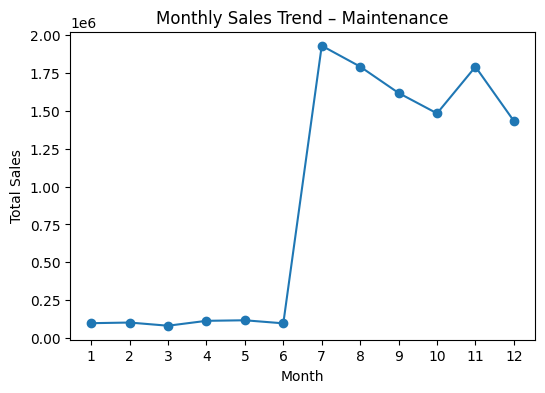

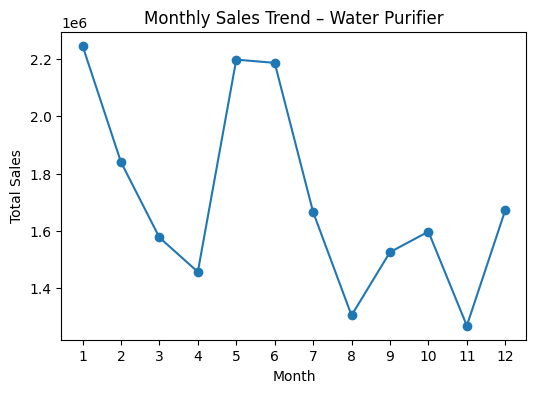

In [10]:
for product in df['Product_Type'].unique():
    product_sales = (
        df[df['Product_Type'] == product]
        .groupby('Month_Num')['Total_Sale']
        .sum()
    )

    plt.figure(figsize=(6,4))
    plt.plot(product_sales.index, product_sales.values, marker='o')
    plt.title(f"Monthly Sales Trend – {product}")
    plt.xlabel("Month")
    plt.ylabel("Total Sales")
    plt.xticks(range(1,13))
    plt.show()


**Sales by Location**

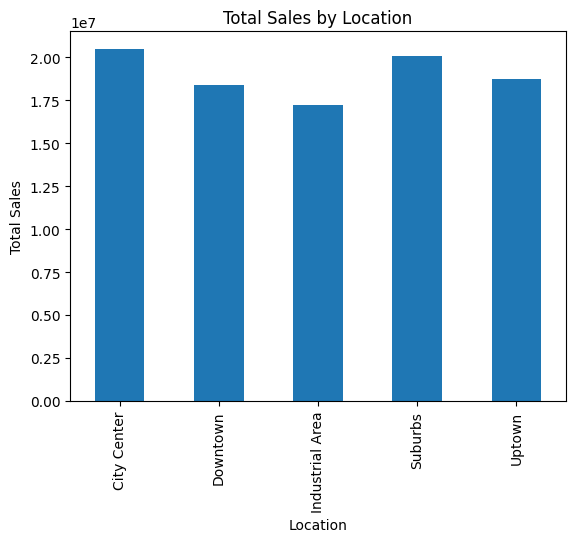

In [11]:
df.groupby("Location")["Total_Sale"].sum().plot(kind="bar")
plt.title("Total Sales by Location")
plt.xlabel("Location")
plt.ylabel("Total Sales")
plt.show()


**Sales by Customer Category**

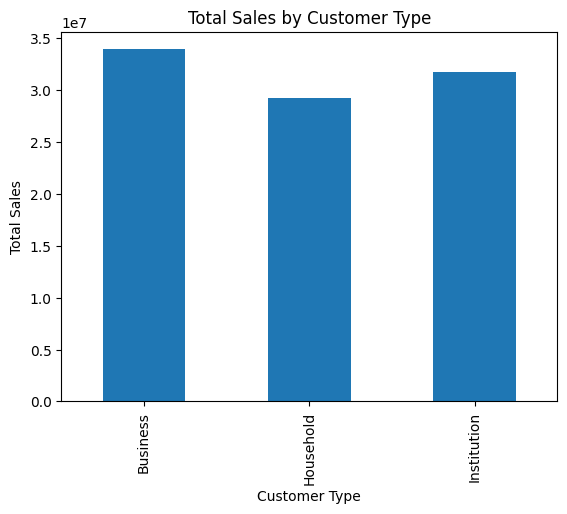

In [12]:
df.groupby("Customer_Type")["Total_Sale"].sum().plot(kind="bar")
plt.title("Total Sales by Customer Type")
plt.xlabel("Customer Type")
plt.ylabel("Total Sales")
plt.show()


**Seasonal pattern (Month)**

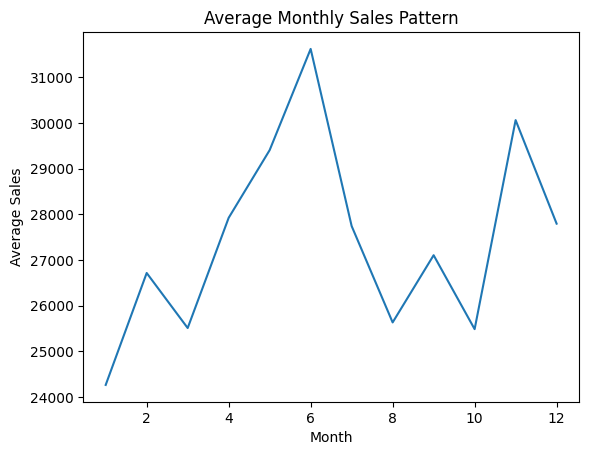

In [13]:
monthly_avg = df.groupby("Month_Num")["Total_Sale"].mean()

plt.plot(monthly_avg)
plt.title("Average Monthly Sales Pattern")
plt.xlabel("Month")
plt.ylabel("Average Sales")
plt.show()


# **TIME-BASED EDA (TIME SERIES VISUALISATION)**

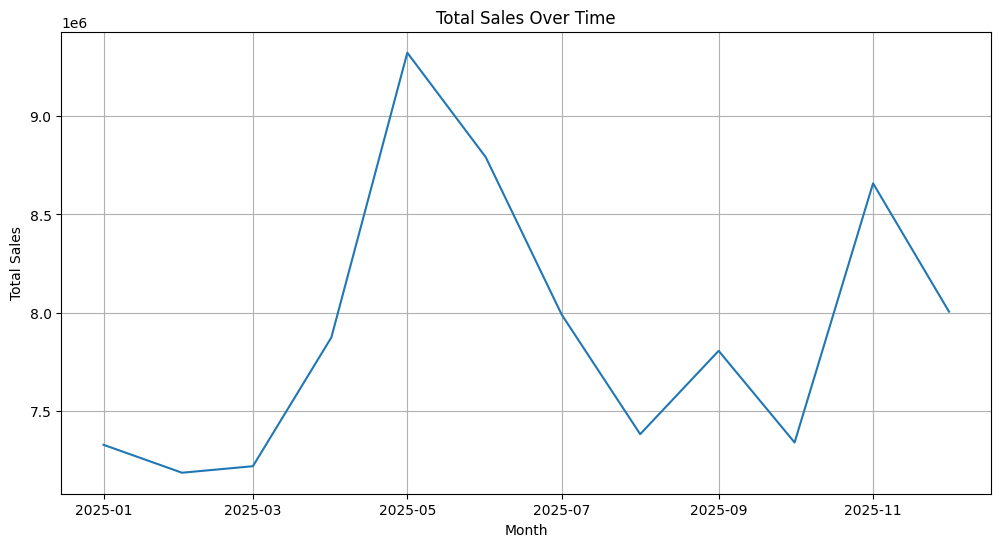

In [14]:
if not pd.api.types.is_datetime64_any_dtype(df['month']):
    df["month"] = pd.to_datetime(df["month"].astype(str) + ' 2025', format='%B %Y')
    # Aggregate total sales by month
df_time = df.groupby('month')['Total_Sale'].sum().reset_index()

# Plotting time series of total sales
plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='Total_Sale', data=df_time)
plt.title('Total Sales Over Time')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()


## **CORRELATION ANALYSIS (NUMERIC VARIABLES ONLY)**

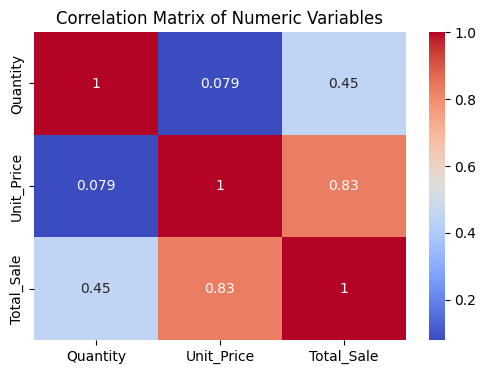

In [15]:
numeric_df = df.select_dtypes(include=["int64", "float64"])
numeric_df = numeric_df.drop(columns=["Month_Num"])
numeric_df = numeric_df.drop(columns=["Month_Num"], errors="ignore")
plt.figure(figsize=(6,4))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Numeric Variables")
plt.show()



**Product × Month Heatmap**

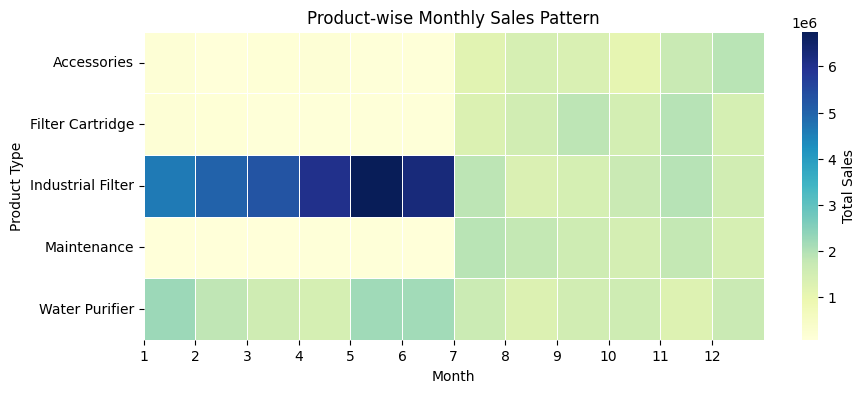

In [17]:
plt.figure(figsize=(10,4))

sns.heatmap(
    pivot,
    cmap="YlGnBu",
    annot=False,        # remove numbers
    linewidths=0.5,
    cbar_kws={"label": "Total Sales"}
)

plt.title("Product-wise Monthly Sales Pattern")
plt.xlabel("Month")
plt.ylabel("Product Type")
plt.xticks(range(0,12), range(1,13))
plt.show()


Light colors → low sales

Dark colors → high sales

Rows (horizontal) → product behaviour across months

Columns (vertical) → seasonal demand across products

Dark patches → peak demand periods

Light patches → low sales periods


In [18]:
product_monthly = df.groupby(
    ["Product_Type", "Month_Num"]
)["Total_Sale"].sum().reset_index()

In [19]:
df_encoded = pd.get_dummies(
    df,
    columns=["Product_Type", "Location", "Customer_Type", "Payment_Mode", "Service_Type"],
    drop_first=True
)

In [20]:
X = df_encoded.drop(columns=["Total_Sale", "month", "Invoice_ID"])
y = df_encoded["Total_Sale"]

In [21]:
X = df_encoded.drop(columns=["Total_Sale", "month", "Invoice_ID"])
y = df_encoded["Total_Sale"]

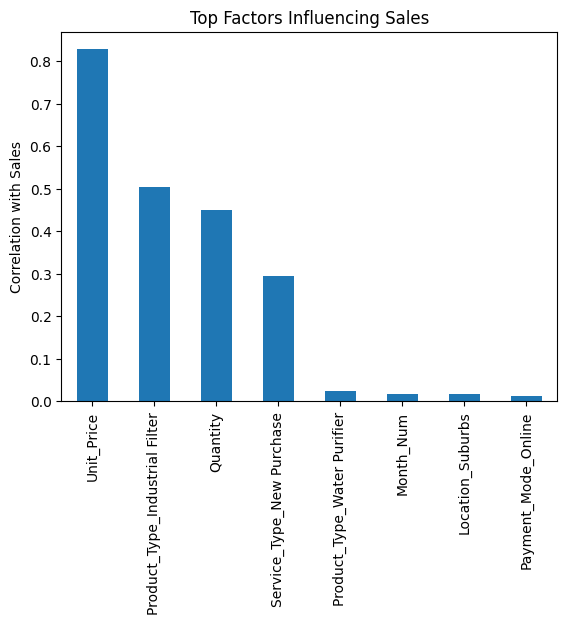

In [22]:
# plot top influencing factors
corr = df_encoded.corr(numeric_only=True)['Total_Sale'].sort_values(ascending=False)
corr_top = corr.drop('Total_Sale').head(8)

plt.figure()
corr_top.plot(kind='bar')
plt.title("Top Factors Influencing Sales")
plt.ylabel("Correlation with Sales")
plt.show()

In [23]:

 product_monthly_sales = df.groupby(
    ["month", "Product_Type"]
)["Total_Sale"].sum().reset_index()

product_monthly_sales.head()


,month,Product_Type,Total_Sale
0,2025-01-01,Accessories,183499
1,2025-01-01,Filter Cartridge,165879
2,2025-01-01,Industrial Filter,4635335
3,2025-01-01,Maintenance,97908
4,2025-01-01,Water Purifier,2246304
